# Comparison TPV tracks and MCS observations 

In [12]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from tpv_analysis import get_tracks, check_overlap, check_overlap_tcs
import warnings
warnings.filterwarnings('ignore')

## Get TPV tracks 

In [213]:
filename='tpv_files_JuliaK/tpv_2014.real_time'
tpv = get_tracks(filename, 2014)

## Get MCS tracks 

In [175]:
# read in CTT tracks heavy rain core 
tbb = '/media/juli/Data/projects/mcs_tracking/trackdata/meso-alpha/Tracks_2014_heavy_rain_core.h5'
mcs= pd.read_hdf(tbb, 'table')
mcs.timestr = pd.to_datetime(mcs.timestr) 

## Overlap check for 15 years of TCS and TPV  

In [332]:
def check_overlap(tpv,mcs,rad):
    """
    Check the overlap between TPV (before they are moving off) and MCS tracks. 
    
    Args: 
    tpv: pandas.DataFrame with TPV tracks 
    mcs: pandas.DataFrame with MCS tracks 
    rad: radius in which to look for TPV 
    
    Returns:
    tpv overlap: TPV with MCS in vicinity 
    tpv_no_mcs: TPV of same class without MCS in radius 
    
    """
    from bisect import bisect_left
    tpv_overlap = pd.DataFrame(columns = tpv.columns)
    perc = 1.1 
    
    # loop through months 
    for mon in np.arange(1,13):
        tpvmon = tpv[tpv.time.dt.month== mon]
        for tpv_id in np.unique(tpvmon.id.values):
            overlap = False 
            tpv_case= tpvmon[tpvmon.id == tpv_id]
            start = tpv_case.time.values[0]
            end = tpv_case.time.values[-1] + np.timedelta64(1,'D')
            tpv_case['lon'] =pd.to_numeric(tpv_case['lon'])
            tpv_case['lat'] =pd.to_numeric(tpv_case['lat'])
            tpv_case['precip'] =pd.to_numeric(tpv_case['precip'])

            # only off-moving 
            if tpv_case.lon.values[-1] < 105:
            # only heavy rain 
            #if (tpv_case.precip.values >= perc).sum() > 0:
                total[mon-1] += 1 
                # loop through mcs dates
                uniqueflag= 0
                for cell in np.unique(mcs.cell.values):
                    if overlap is True: 
                        break 
                    # do the whole thing per year to really get individual cell IDs
                    subset = mcs[mcs.cell == cell]
                    # check whether MCS has a time overlap with TPV
                    timeoverlap = subset[ (subset.timestr >= start) & (subset.timestr <= end)]
                    if timeoverlap.shape[0]> 0:
                        # check whether in a timestep, an MCS is within 3 deg radius 
                        for t in timeoverlap.timestr.values:
                            mcslat = timeoverlap[timeoverlap.timestr== t].latitude.values[0]
                            mcslon = timeoverlap[timeoverlap.timestr== t].longitude.values[0]
                            # get the closes timestep in TPV set!
                            i = bisect_left(tpv_case.time.values, t)
                            tpvt= min(tpv_case.time.values[max(0, i-1): i+2], key=lambda ts: abs(t - ts))
                            tpvlon= tpv_case[tpv_case.time == tpvt].lon.values[0]
                            tpvlat= tpv_case[tpv_case.time == tpvt].lat.values[0]
                            # check for overlap in space
                            if (mcslat > tpvlat - rad) & (mcslat < tpvlat + rad) & (mcslon < tpvlon + rad) & (mcslon < tpvlon + rad):
                                overlap = True 
                                uniqueflag +=1
                                tpv_overlap = tpv_overlap.append(tpv_case[tpv_case.time == tpvt])
                                break      
                                
                    
                                
                            
                                

    return tpv_overlap

In [298]:
tpv_overlap= check_overlap(tpv, mcs, 3)

In [333]:
tpv_overlap_all= pd.DataFrame(columns = tpv.columns)
total_all = pd.DataFrame(columns = tpv.columns)
rad = 3

for y in np.arange(2000,2016):
    print(y)
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tpv = get_tracks(filename, y)
    
    # mcs data 
    tbb = '/media/juli/Data/projects/mcs_tracking/trackdata/meso-alpha/Tracks_' + str(y)+ '_heavy_rain_core.h5'
    mcs= pd.read_hdf(tbb, 'table')
    mcs.timestr = pd.to_datetime(mcs.timestr) 
    
    # overlap check 
    tpv_overlap  = check_overlap(tpv, mcs, rad)
    tpv_overlap_all = tpv_overlap_all.append(tpv_overlap)

# save subdataset 
tpv_overlap_all.to_hdf('tpv_mcs_subdataset_composites_within-tp.h5', 'table')

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


In [331]:
tpv_overlap_all.shape

(82, 9)

In [563]:
def check_overlap_tpv(tpv,mcs,rad):
    """
    Check the overlap between TPV (before they are moving off) and MCS tracks. 
    
    Args: 
    tpv: pandas.DataFrame with TPV tracks 
    mcs: pandas.DataFrame with MCS tracks 
    rad: radius in which to look for TPV 
    
    Returns:
    tpv overlap: TPV with MCS in vicinity 
    tpv_no_mcs: TPV of same class without MCS in radius 
    
    """
    from bisect import bisect_left
    tpv_overlap = np.zeros((12,))
    total= np.zeros((12,))
    perc = 1.1 
    
    # loop through months 
    for mon in np.arange(1,13):
        tpvmon = tpv[tpv.time.dt.month== mon]
        for tpv_id in np.unique(tpvmon.id.values):
            overlap = False 
            tpv_case= tpvmon[tpvmon.id == tpv_id]
            start = tpv_case.time.values[0]
            end = tpv_case.time.values[-1] + np.timedelta64(1,'D')
            tpv_case['lon'] =pd.to_numeric(tpv_case['lon'])
            tpv_case['lat'] =pd.to_numeric(tpv_case['lat'])
            tpv_case['precip'] =pd.to_numeric(tpv_case['precip'])

            # only off-moving 
            #if tpv_case.lon.values[-1] >= 105:
            # only heavy rain 
            if (tpv_case.precip.values >= perc).sum() > 0:
                total[mon-1] += 1 
                # loop through mcs dates
                for cell in np.unique(mcs.cell.values):
                    if overlap is True: 
                        break 

                    # do the whole thing per year to really get individual cell IDs
                    subset = mcs[mcs.cell == cell]
                    # check whether MCS has a time overlap with TPV
                    timeoverlap = subset[ (subset.timestr >= start) & (subset.timestr <= end)]
                    if timeoverlap.shape[0]> 0:
                        # check whether in a timestep, an MCS is within 3 deg radius 
                        for t in timeoverlap.timestr.values:
                            mcslat = timeoverlap[timeoverlap.timestr== t].latitude.values[0]
                            mcslon = timeoverlap[timeoverlap.timestr== t].longitude.values[0]
                            # get the closes timestep in TPV set!
                            i = bisect_left(tpv_case.time.values, t)
                            tpvt= min(tpv_case.time.values[max(0, i-1): i+2], key=lambda ts: abs(t - ts))
                            tpvlon= tpv_case[tpv_case.time == tpvt].lon.values[0]
                            tpvlat= tpv_case[tpv_case.time == tpvt].lat.values[0]
                            # check for overlap in space
                            if (mcslat > tpvlat - rad) & (mcslat < tpvlat + rad) & (mcslon < tpvlon + rad) & (mcslon < tpvlon + rad):
                                tpv_overlap[mon-1] += 1
                                overlap = True 
                                break      

    return tpv_overlap,total  

In [215]:
tpv_overlap , total = check_overlap_tpv(tpv, mcs, 3)

In [547]:
tpv.groupby(tpv.time.dt.month).count().iloc[:, 0].sum()

1335

In [ ]:
    # count seasonal 
    mcs_monthly_counts = mcs.groupby(mcs.time.dt.month)['cell'].nunique()
    tpv_monthly_counts = tpv.groupby(tpv.time.dt.month)['id'].nunique()

    for i in tpv_monthly_counts.index.values-1:
        tpv_seasonal[i] += tpv_monthly_counts[tpv_monthly_counts.index == i+1].iloc[0]

    for i in mcs_monthly_counts.index.values-1:
        mcs_seasonal[i] +=  mcs_monthly_counts[ mcs_monthly_counts.index == i+1].iloc[0]
        
        tpv_seasonal = np.zeros((12,))
mcs_seasonal = np.zeros((12,))


In [564]:
tpv_overlap_hr = np.zeros((12,))
total_hr = np.zeros((12,))

rad = 3
for y in np.arange(2000,2016):
    print(y)
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tpv = get_tracks(filename, y)
    
    # mcs data 
    tbb = '/media/juli/Data/projects/mcs_tracking/trackdata/meso-alpha/Tracks_' + str(y)+ '_heavy_rain_core.h5'
    mcs= pd.read_hdf(tbb, 'table')
    mcs.timestr = pd.to_datetime(mcs.timestr) 
    
    # overlap check 
    tpv_overlap , total = check_overlap_tpv(tpv, mcs, 3)
    tpv_overlap_hr += tpv_overlap 
    total_hr += total

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


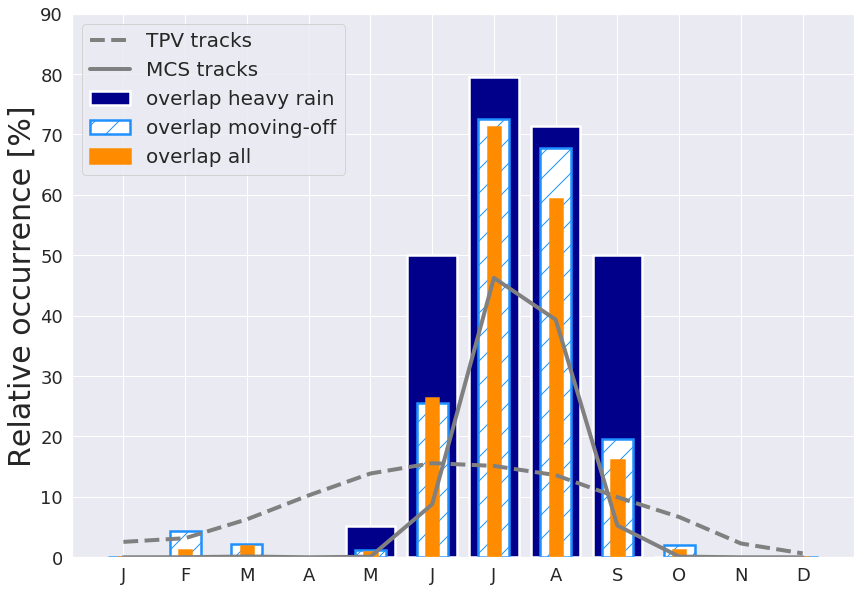

In [558]:
## overlap figure ## 
import seaborn as sns
sns.set()

plt.figure(figsize=(14,10))
plt.bar(np.arange(12), tpv_overlap_hr/total_hr * 100 , label = 'overlap heavy rain', color = 'darkblue', linewidth = 2.5)
plt.bar(np.arange(12), tpv_overlap_off/total_off * 100, label = 'overlap moving-off' , edgecolor = 'dodgerblue', color = 'white', hatch = '/',width= 0.5, linewidth = 2.5)
plt.bar(np.arange(12), tpv_overlap_all/total_all * 100 , label = 'overlap all', edgecolor = 'darkorange', color ='darkorange', width= 0.2, linewidth = 2.5)

plt.plot(tpv_seasonal/tpv_seasonal.sum() * 100, color = 'grey', linestyle = '--', label = 'TPV tracks', linewidth= 4)
plt.plot(mcs_seasonal/mcs_seasonal.sum() * 100, color = 'grey', linestyle = '-', label = 'MCS tracks', linewidth= 4)

plt.ylabel('Relative occurrence [%]', fontsize= 30)
plt.yticks(np.arange(0,100,10),np.arange(0,100,10), fontsize= 18 )
plt.xticks(np.arange(12), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize= 18)
plt.legend(fontsize= 20)

plt.savefig('tpv_mcs_overlap_2000-2015_beta_tpvmcs.png')
plt.show()

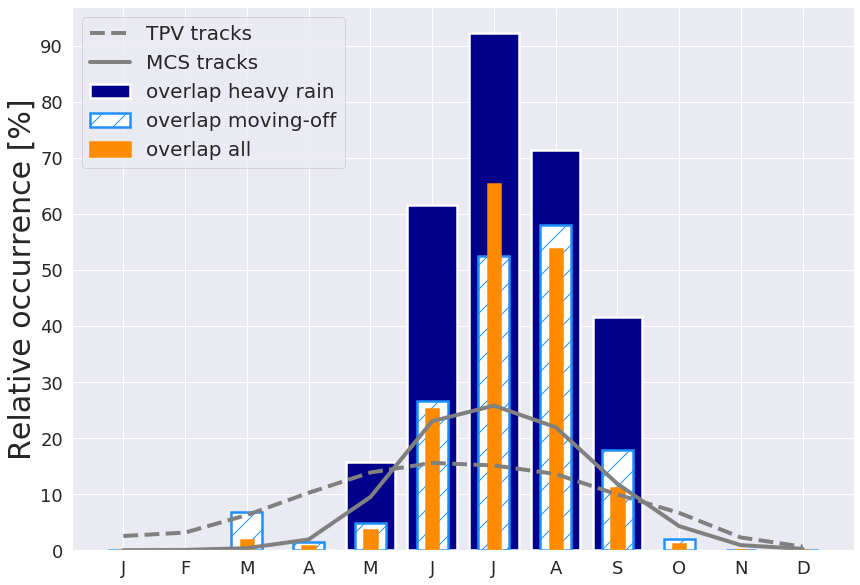

In [565]:
## overlap figure ## 
sns.set()

plt.figure(figsize=(14,10))
plt.bar(np.arange(12), tpv_overlap_hr/total_hr * 100 , label = 'overlap heavy rain', color = 'darkblue', linewidth = 2.5)
plt.bar(np.arange(12), tpv_overlap_off/total_off * 100, label = 'overlap moving-off' , edgecolor = 'dodgerblue', color = 'white', hatch = '/',width= 0.5, linewidth = 2.5)
plt.bar(np.arange(12), tpv_overlap_all/total_all * 100 , label = 'overlap all', edgecolor = 'darkorange', color ='darkorange', width= 0.2, linewidth = 2.5)

plt.plot(tpv_seasonal/tpv_seasonal.sum() * 100, color = 'grey', linestyle = '--', label = 'TPV tracks', linewidth= 4)
plt.plot(mcs_seasonal/mcs_seasonal.sum() * 100, color = 'grey', linestyle = '-', label = 'MCS tracks', linewidth= 4)

plt.ylabel('Relative occurrence [%]', fontsize= 30)
plt.yticks(np.arange(0,100,10),np.arange(0,100,10), fontsize= 18 )
plt.xticks(np.arange(12), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize= 18)
plt.legend(fontsize= 20)


plt.savefig('tpv_mcs_overlap_2000-2015_alpha.png')
plt.show()

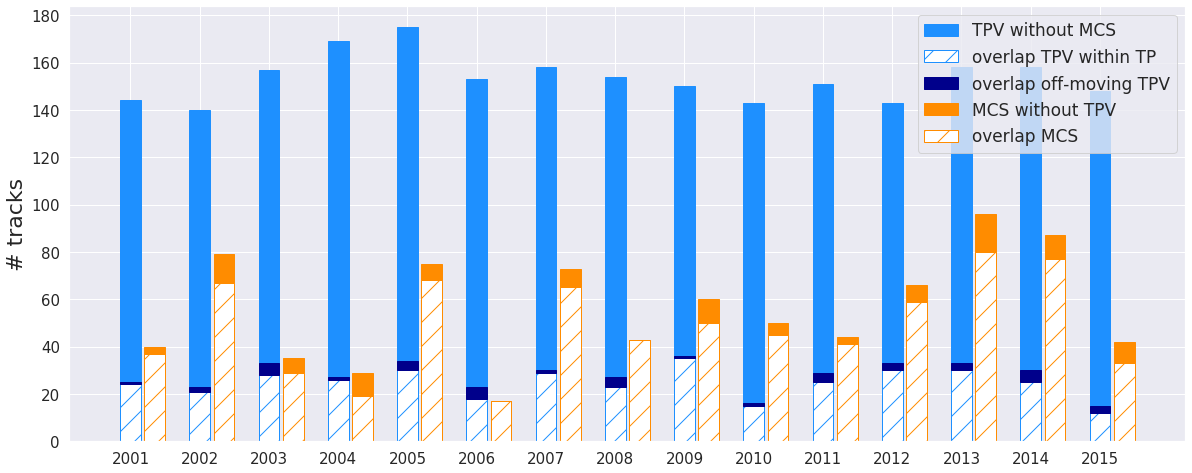

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
plt.figure(figsize= (20,8))
years = np.arange(2001,2016)
w = 0.3
# TPV 
plt.bar(years, cellcount_tpv, edgecolor = 'dodgerblue', color = 'dodgerblue', label= 'TPV without MCS', width =w)
plt.bar(years,  total_overlap, edgecolor = 'dodgerblue', color = 'white', hatch = '/', label = 'overlap TPV within TP', width =w)
plt.bar(years,  total_overlap_off, bottom = total_overlap, edgecolor ='darkblue' ,color = 'darkblue',label = 'overlap off-moving TPV', width =w)


# MCS 
plt.bar(years + 0.35, cellcount_mcs,edgecolor = 'darkorange', color = 'darkorange', label = 'MCS without TPV', width =w)
plt.bar(years+ 0.35, cellcount_mcs - total_mcs , edgecolor = 'darkorange', color ='white',  hatch = '/', label = 'overlap MCS', width =w)

plt.xticks(years, fontsize= 15)
plt.yticks(np.arange(0,200,10)[::2], fontsize= 15)
plt.legend(fontsize= 17)

plt.ylabel('# tracks', fontsize= 22)
plt.savefig('TCS_and_TPV.png')
plt.show()

- many occurrences of TPV without any MCS over the TP 
- little MCS without the occurrence of TPV (mostly non-off moving)
- probably due to the high frequency of TPV occurrences (every 3rd day)

## Comparison between off-mocing TPV and off-moving MCS 

In [6]:
tpb_east = pd.read_hdf('../CTT/analysis/TPB_east_cells.h5', 'table')

In [2]:
tpv = get_tracks('tpv_files_JuliaK/tpv_2001.real_time', 2001)
for y in np.arange(2002,2016):
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tracks = get_tracks(filename, y)
    tpv = tpv.append(tracks)

In [3]:
# drop cells that are not off-moving 
tpv_off = pd.DataFrame(columns = tpv.columns)
for y in np.arange(2000,2016):
    subset= tpv[tpv.time.dt.year == y]
    for cell in np.unique(subset.id.values):
        if subset[subset.id == cell].lon.values[-1] >= 105:
            tpv_off= tpv_off.append(subset[subset.id == cell])

In [7]:
# get only cells over Sichuan basin 
mcs_off = tpb_east[(tpb_east.longitude >= 100) &(tpb_east.longitude <= 110) &(tpb_east.latitude > 25)]

In [8]:
total_mcs= np.zeros((15,))
total_tpv= np.zeros((15,))
total_overlap= np.zeros((15,))
total_mcsoverlap= np.zeros((15,))
cellcount_mcs = np.zeros((15,))
cellcount_tpv = np.zeros((15,))

for y in np.arange(2001,2016):
    # tpv data 
    tpv = tpv_off[tpv_off.time.dt.year == y]
    
    # mcs data 
    mcs = mcs_off[mcs_off.time.dt.year == y]
    
    # overlap check 
    i = y - 2001
  
    tpv_overlap, tpv_no_mcs, mcs_no_tpv, all_mcs, all_tpv, mcs_overlap = check_overlap(tpv,mcs)
    total_overlap[i] = np.shape(tpv_overlap[tpv_overlap > 0])[0]
    total_mcsoverlap[i] = mcs_overlap
    # cases with no overlap 
    total_tpv[i] =  tpv_no_mcs
    total_mcs[i] =  mcs_no_tpv
    # total numbers for check 
    cellcount_mcs[i] = all_mcs 
    cellcount_tpv[i] = all_tpv

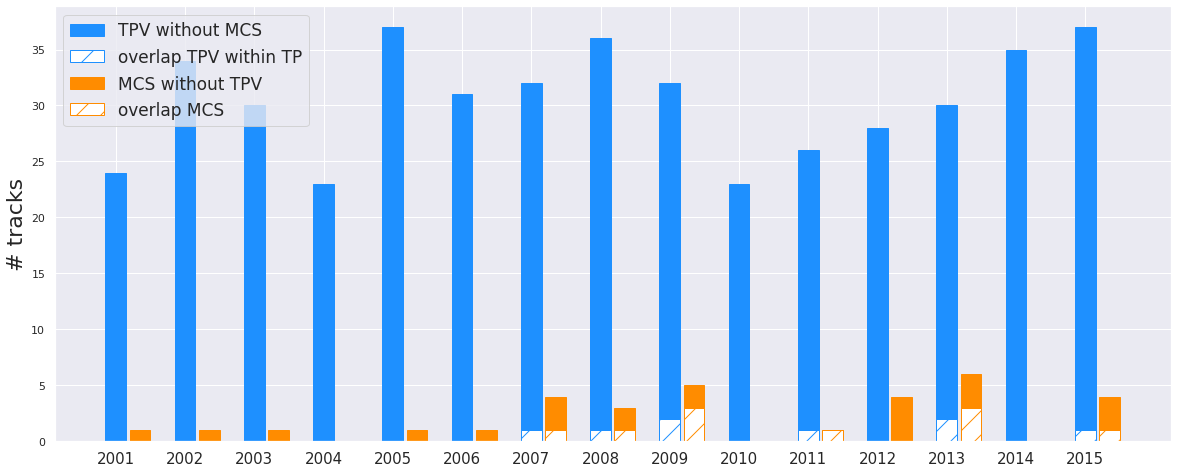

In [10]:
import seaborn as sns 
sns.set()
plt.figure(figsize= (20,8))
years = np.arange(2001,2016)
w = 0.3
# TPV 
plt.bar(years, cellcount_tpv, edgecolor = 'dodgerblue', color = 'dodgerblue', label= 'TPV without MCS', width =w)
plt.bar(years,  total_overlap, edgecolor = 'dodgerblue', color = 'white', hatch = '/', label = 'overlap TPV within TP', width =w)


# MCS 
plt.bar(years + 0.35, cellcount_mcs, edgecolor = 'darkorange', color = 'darkorange', label = 'MCS without TPV', width =w)
plt.bar(years+ 0.35, cellcount_mcs - total_mcs , edgecolor = 'darkorange', color ='white',  hatch = '/', label = 'overlap MCS', width =w)

plt.xticks(years, fontsize= 15)
#plt.yticks(np.arange(0,20,10)[::2], fontsize= 15)
plt.legend(fontsize= 17)

plt.ylabel('# tracks', fontsize= 22)
plt.savefig('TCS_and_TPV_off.png')
plt.show()

In [9]:
total_mcsoverlap.sum()

13.0

In [22]:
total_mcsoverlap.sum()/ cellcount_mcs.sum() * 100 

31.25

In [573]:
help(np.histogram)

Help on function histogram in module numpy:

histogram(a, bins=10, range=None, normed=None, weights=None, density=None)
    Compute the histogram of a set of data.
    
    Parameters
    ----------
    a : array_like
        Input data. The histogram is computed over the flattened array.
    bins : int or sequence of scalars or str, optional
        If `bins` is an int, it defines the number of equal-width
        bins in the given range (10, by default). If `bins` is a
        sequence, it defines a monotonically increasing array of bin edges,
        including the rightmost edge, allowing for non-uniform bin widths.
    
        .. versionadded:: 1.11.0
    
        If `bins` is a string, it defines the method used to calculate the
        optimal bin width, as defined by `histogram_bin_edges`.
    
    range : (float, float), optional
        The lower and upper range of the bins.  If not provided, range
        is simply ``(a.min(), a.max())``.  Values outside the range are
      

## Comparison of geopotential distributions TPV with MCS and other TPVs 

In [606]:
alltracks = pd.DataFrame(columns = overlap.columns)
for y in np.arange(2000,2016):
    print(y)
    # tpv data 
    filename='tpv_files_JuliaK/tpv_' + str(y)+'.real_time'
    tpv = get_tracks(filename, y)
    alltracks= alltracks.append(tpv)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


In [751]:
np.unique(alltracks.id.values).shape

(2104,)

In [749]:
lifetimes_all.shape

(468,)

In [767]:
lifetimes_all= np.array(())
lifetimes= np.array(())
subset= pd.DataFrame(columns=overlap.columns)

for y in np.arange(2000, 2015):
    ytracks= alltracks[alltracks.time.dt.year==y]
    ytracks['lon'] = pd.to_numeric(ytracks.lon)
    for cell in np.unique(ytracks.id.values):
        if ytracks[ytracks.id==cell].lon.values.max() >105:
            lt=ytracks[ytracks.id==cell].shape[0]*6
            lifetimes_all=np.append(lifetimes_all,lt)
            if cell in np.unique(overlap.id.values):
                lifetimes= np.append(lifetimes,ytracks[ytracks.id==cell].shape[0]*6)
                subset=subset.append(ytracks[ytracks.id== cell])

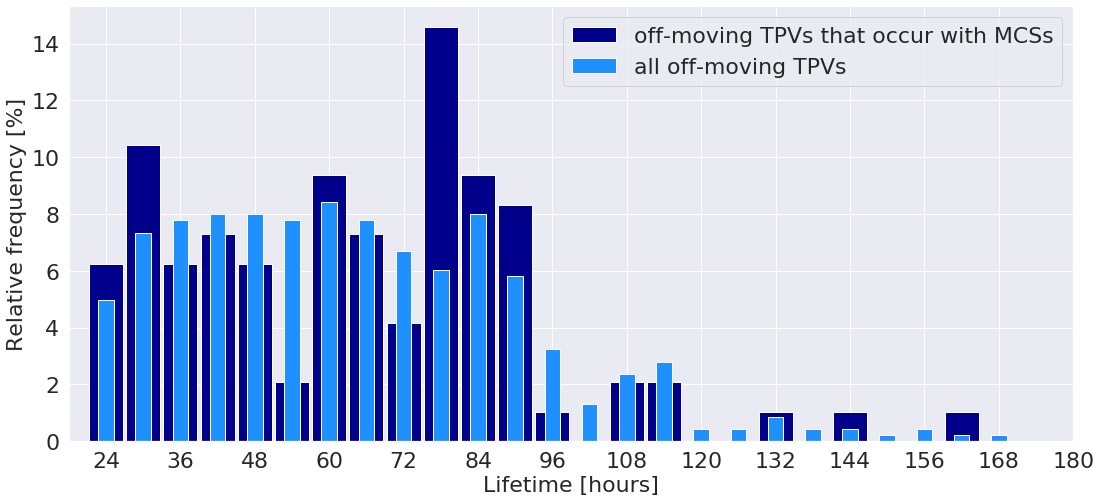

In [803]:
hei,bi = np.histogram(lifetimes, bins = np.arange(24,24*10,6))
heig,bis= np.histogram(lifetimes_all,bins =np.arange(24,24*10,6))

plt.figure(figsize= (18,8))

fs= 22 
plt.bar(bi[0:-1], hei/ hei.sum()* 100 , width= 5.5, label = 'off-moving TPVs that occur with MCSs', color = 'darkblue')   
plt.bar(bis[0:-1], heig/ heig.sum() * 100, width= 2.5, label = 'all off-moving TPVs', color= 'dodgerblue')

plt.xlabel('Lifetime [hours]', fontsize= fs)
plt.ylabel('Relative frequency [%]', fontsize= fs)
plt.legend(fontsize= fs)

#plt.xticks(np.arange(5400,6000,100), np.arange(5400,6000,100), fontsize= 17)
plt.yticks(np.arange(0,16,2), np.arange(0,16,2), fontsize= 22)
plt.xticks(np.arange(24,24*8,12),np.arange(24,24*8,12), fontsize= 22)
plt.xlim(18,180)

plt.savefig('lifetime_distribution.png')

In [768]:
subset.geopm

393    5787.215087
394    5774.566769
395    5767.467890
396    5765.577982
397    5751.128440
          ...     
854    5845.497452
855    5839.454638
856    5839.128440
857    5834.744139
858    5828.778797
Name: geopm, Length: 1031, dtype: float64

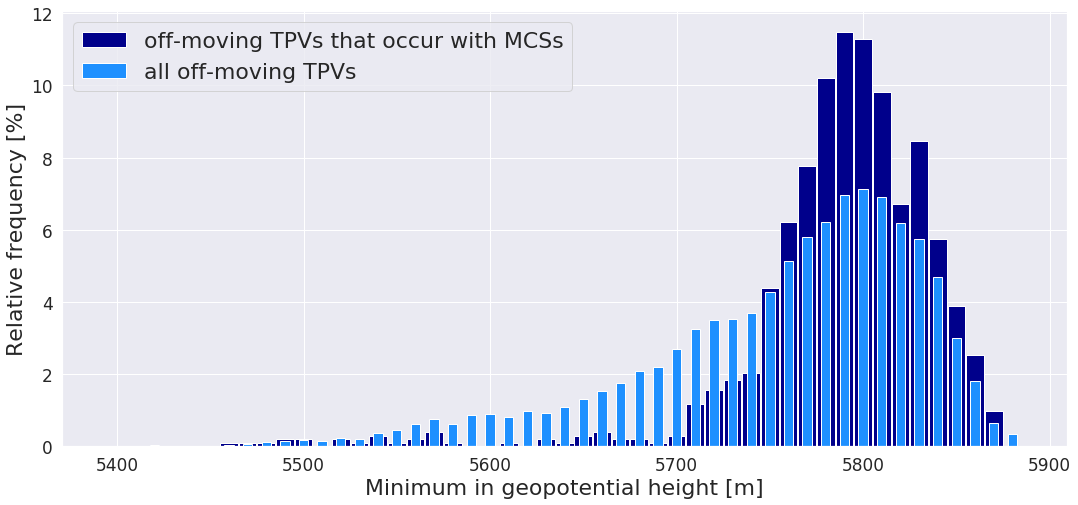

In [805]:
plt.figure(figsize= (18,8))

fs= 22 
g= 9.81
overlap = pd.read_hdf('tpv_mcs_subdataset.h5', 'table')
subset['geopm'] = pd.to_numeric(subset.geopm) 
heights, bins = np.histogram(subset.geopm.values, bins= np.arange(5400,5900, 10))

heights_all, bins = np.histogram(alltracks.geopm.values, bins= np.arange(5400,5900, 10))
   
plt.bar(bins[0:-1], heights/ heights.sum()* 100 , width= 9.5, label = 'off-moving TPVs that occur with MCSs', color = 'darkblue')   
plt.bar(bins[0:-1], heights_all/ heights_all.sum() * 100, width= 5, label = 'all off-moving TPVs', color= 'dodgerblue')

plt.xlabel('Minimum in geopotential height [m]', fontsize= fs)
plt.ylabel('Relative frequency [%]', fontsize= fs)
plt.legend(fontsize= fs)
plt.xticks(np.arange(5400,6000,100), np.arange(5400,6000,100), fontsize= 17)
plt.yticks(np.arange(0,14,2), np.arange(0,14,2), fontsize= 17)

plt.savefig('geopotential_distribution.png')

- check relationship between overlaps (do stronger TPV lead to stronger MCS? )
- check what are the TPV that have multiple MCS associated with it 
- compare only strong TPV or only TPV with more rain associated 


**- TPV (moving off) and TPB east/MCS initiated in Sichuan basin (lat > 25N, lon< 110 E )**
- 10 from 32 MCS have a time overlap with the TPV 